[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'^GSPC'}, xlabel='Date'>

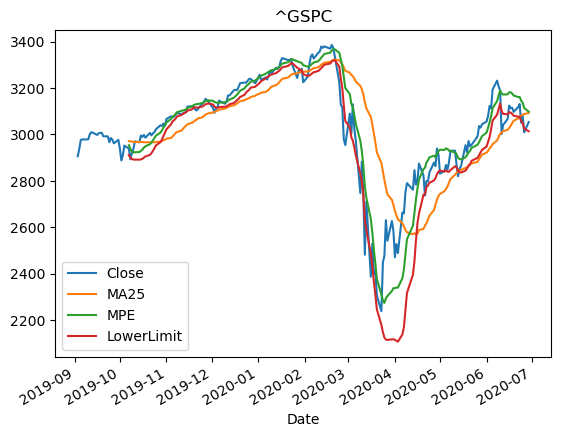

In [19]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyfinance.ols import RollingOLS, PandasRollingOLS
from scipy.stats import norm
import pandas_ta as ta

def steyx(df):
    n=len(df)
    y=df['Close'].values
    x=df['X'].values
    fit = np.polyfit(x,y,deg=1)
    n = len(x)
    m = fit[0]
    c = fit[1]
    y_pred = m*x+c
    STEYX = (((y-y_pred)**2).sum()/(n-2))**0.5
    return STEYX

def rolling_pipe(dataframe,window):
    return pd.Series([dataframe.iloc[i-window: i].pipe(steyx) 
                      if i >= window else None 
                      for i in range(1, len(dataframe)+1)],
                     index = dataframe.index)

window=25
ticker='^GSPC'
df=yf.download(tickers= ticker,start= '2019-9-01', end='2020-6-30',interval = "1d",
                     group_by = 'column',auto_adjust = True, prepost = True, 
                     proxy = None)
#df=pd.read_csv("ols.csv")
df['X'] = np.arange(len(df))+1
r=PandasRollingOLS(df['Close'], df['X'], window)
df['MPE']=r.alpha+r.beta['feature1']*df['X']
df['SEE']=df.pipe(rolling_pipe, window)

#df['SEE']=np.sqrt(((df['Close']-df['MPE'])).fillna(0)**2/(window-2))
df['LowerLimit']=df['MPE']-1.28*df['SEE']
df['MA25']=df['Close'].rolling(window).mean()
df[['Close','MA25','MPE','LowerLimit']].plot(title=ticker)

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'^GSPC'}, xlabel='Date'>

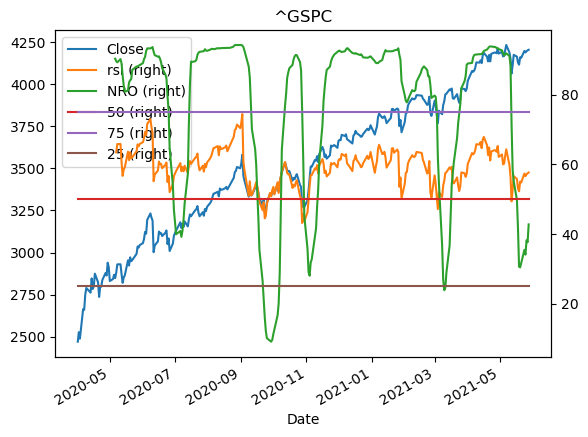

In [21]:

def get_indicator(q, ind_name, params):
    ts = None
    if ind_name == "rsi":
        ts = q.ta.rsi(params['length'])
        
    return ts

window=25
ticker='^GSPC'
df=yf.download(tickers= ticker,start= '2020-4-01',end='2021-05-30',interval = "1d",
                     group_by = 'column',auto_adjust = True, prepost = True, 
                     proxy = None)
#df=pd.read_csv("ols.csv")
df['X'] = np.arange(len(df))+1
r=PandasRollingOLS(df['Close'], df['X'], window)
df['MPE']=r.alpha+r.beta['feature1']*df['X']
df['std_MPE']=(df['MPE']-df['Close'].rolling(window).mean())/df['Close'].rolling(window).std()
df['NRO'] = df['std_MPE'].apply(norm.cdf)*100
df['rsi']=get_indicator(df, 'rsi', {'length': window})
df['50']=50
df['25']=25
df['75']=75
df[['Close','rsi','NRO','50','75','25']].plot(secondary_y=['NRO','rsi','50','25','75'],title=ticker)